In [2]:
# sph related imports
from sph import *
from perlin import *
# neural network rlated imports
from torch.optim import Adam
from rbfConv import *
from torch_geometric.loader import DataLoader
from trainingHelper import *
# plotting/UI related imports
from plotting import *
import matplotlib as mpl
plt.style.use('dark_background')
cmap = mpl.colormaps['viridis']
from tqdm.notebook import trange, tqdm
from IPython.display import display, Latex
from datetime import datetime
from rbfNet import *
from tqdm.notebook import tqdm
import h5py
%matplotlib notebook

In [3]:
trainingFiles = ['./output/' + f for f in os.listdir('./output/') if f.endswith('.hdf5')]

In [4]:
# Load generic settings
inFile = h5py.File(trainingFiles[0],'r')
minDomain = inFile.attrs['minDomain']
maxDomain = inFile.attrs['maxDomain']

baseArea = inFile.attrs['baseArea']
particleRadius = inFile.attrs['particleRadius']
particleSupport = inFile.attrs['particleSupport']

xsphConstant = inFile.attrs['xsphConstant']
diffusionAlpha = inFile.attrs['diffusionAlpha']
diffusionBeta = inFile.attrs['diffusionBeta']
kappa = inFile.attrs['kappa']
restDensity = inFile.attrs['restDensity']
c0 = inFile.attrs['c0']
dt = inFile.attrs['dt']

numParticles = inFile.attrs['numParticles']
timesteps = inFile.attrs['timesteps']

generator = inFile.attrs['generator']
inFile.close()

# Load generator settings
settings = {}
for f in trainingFiles:
    inFile = h5py.File(f,'r')
    generatorSettings = {}
    for k in inFile['generatorSettings'].attrs.keys():
        generatorSettings[k] = inFile['generatorSettings'].attrs[k]
#     print(generatorSettings)
    setup = {}
    setup['generatorSettings'] = generatorSettings
    setup['minDomain'] = inFile.attrs['minDomain']
    setup['maxDomain'] = inFile.attrs['maxDomain']

    setup['baseArea'] = inFile.attrs['baseArea']
    setup['particleRadius'] = inFile.attrs['particleRadius']
    setup['particleSupport'] = inFile.attrs['particleSupport']

    setup['xsphConstant'] = inFile.attrs['xsphConstant']
    setup['diffusionAlpha'] = inFile.attrs['diffusionAlpha']
    setup['diffusionBeta'] = inFile.attrs['diffusionBeta']
    setup['kappa'] = inFile.attrs['kappa']
    setup['restDensity'] = inFile.attrs['restDensity']
    setup['c0'] = inFile.attrs['c0']
    setup['dt'] = inFile.attrs['dt']

    setup['numParticles'] = inFile.attrs['numParticles']
    setup['timesteps'] = inFile.attrs['timesteps']

    setup['generator'] = inFile.attrs['generator']
    settings[f] = setup
    inFile.close()

<IPython.core.display.Javascript object>


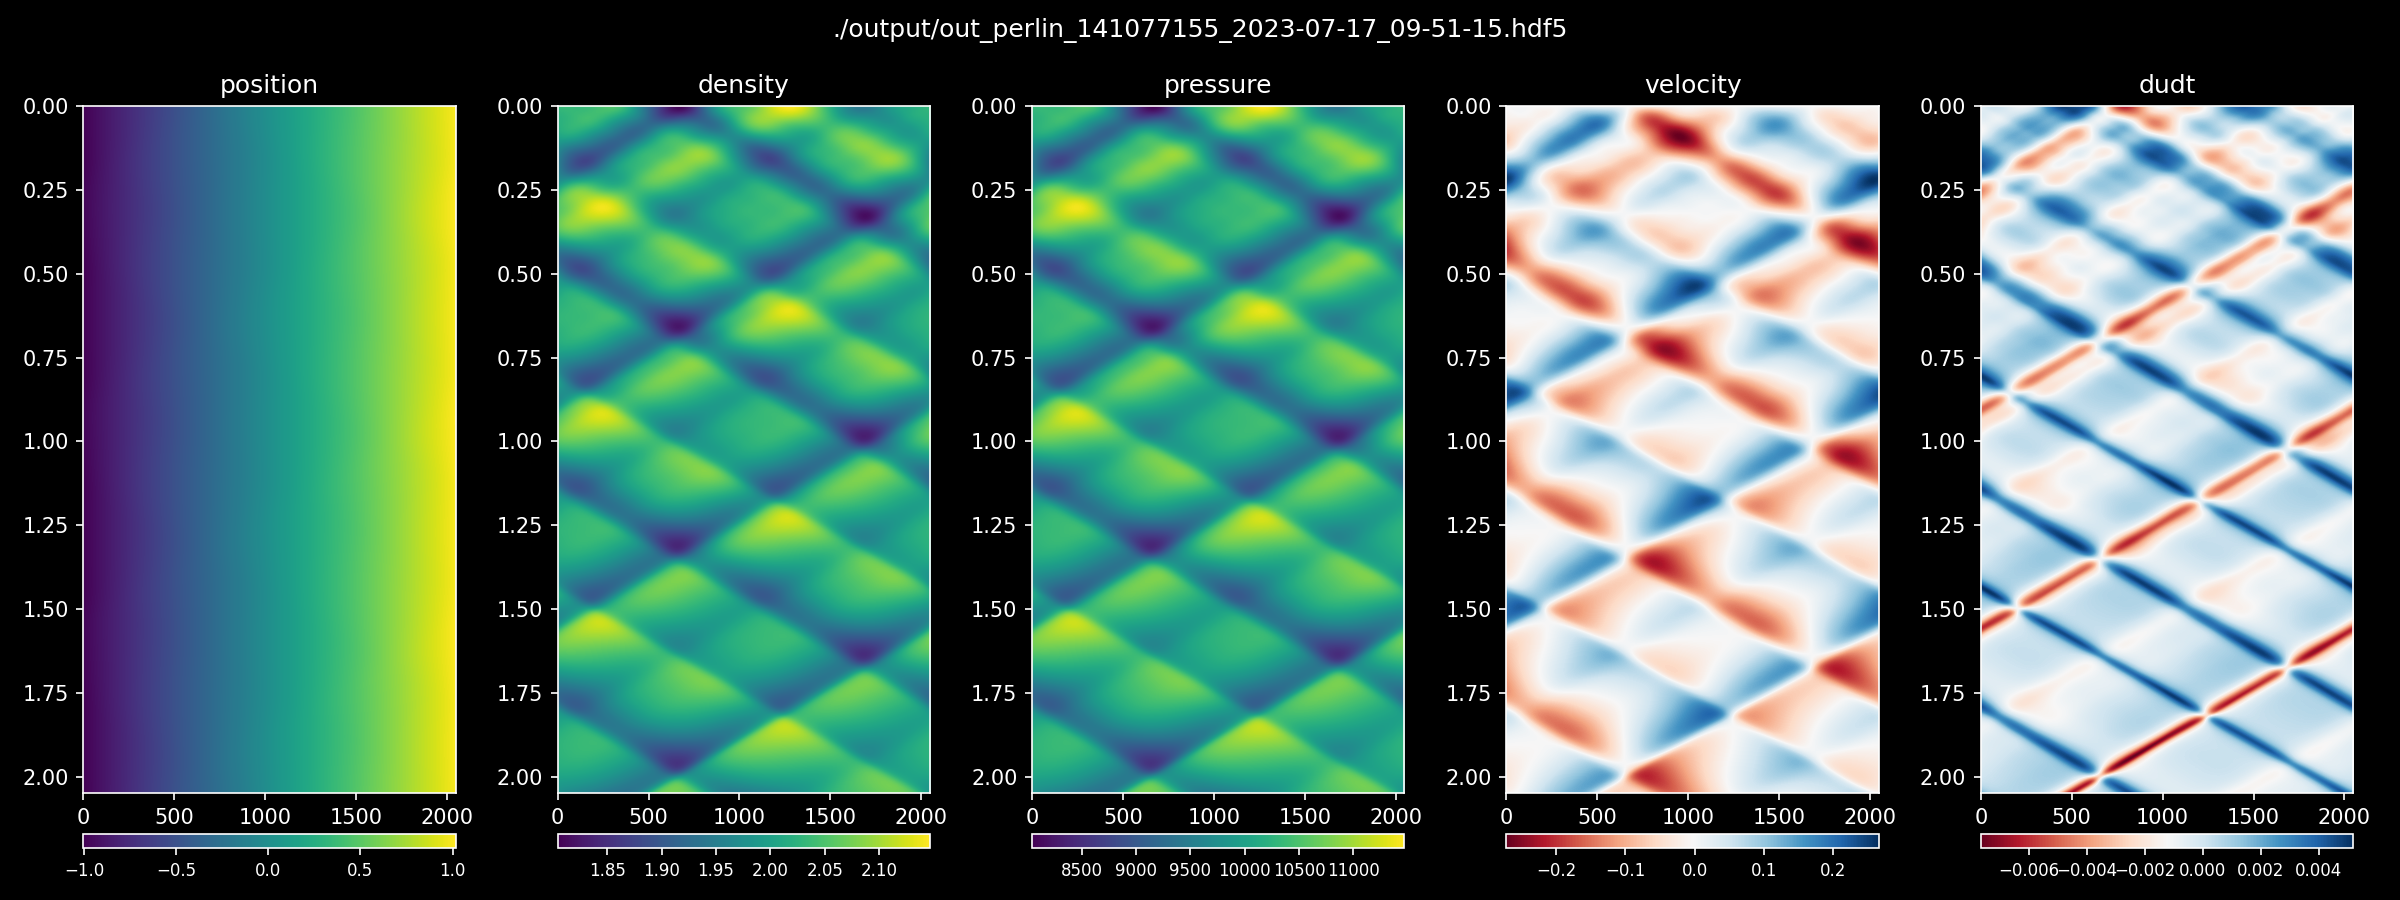

In [5]:
def loadFile(t, plot = False):
    inFile = h5py.File(t,'r')
    fluidPositions = np.array(inFile['simulationData']['fluidPosition'])
    
    fluidVelocities = np.array(inFile['simulationData']['fluidVelocities'])
    fluidDensity = np.array(inFile['simulationData']['fluidDensity'])
    fluidPressure = np.array(inFile['simulationData']['fluidPressure'])
    fluidAreas = np.array(inFile['simulationData']['fluidAreas'])
    dudt = np.array(inFile['simulationData']['dudt'])
    if plot:
        fig, axis = plt.subplots(1, 5, figsize=(16,6), sharex = False, sharey = False, squeeze = False)

        def plot(fig, axis, mat, title, cmap = 'viridis'):
            im = axis.imshow(mat, extent = [0,numParticles,dt * timesteps,0], cmap = cmap)
            axis.axis('auto')
            ax1_divider = make_axes_locatable(axis)
            cax1 = ax1_divider.append_axes("bottom", size="2%", pad="6%")
            cb1 = fig.colorbar(im, cax=cax1,orientation='horizontal')
            cb1.ax.tick_params(labelsize=8) 
            axis.set_title(title)
        plot(fig,axis[0,0], fluidPositions, 'position')
        plot(fig,axis[0,1], fluidDensity, 'density')
        plot(fig,axis[0,2], fluidPressure, 'pressure')
        plot(fig,axis[0,3], fluidVelocities, 'velocity', 'RdBu')
        plot(fig,axis[0,4], dudt, 'dudt', 'RdBu')

        fig.suptitle(trainingFiles[0])
        fig.tight_layout()
    inFile.close()
    return {'positions': torch.tensor(fluidPositions).type(torch.float32), 'density': torch.tensor(fluidDensity).type(torch.float32), 'pressure':torch.tensor(fluidPressure).type(torch.float32), 'area': torch.tensor(fluidAreas).type(torch.float32), 'velocity': torch.tensor(fluidVelocities).type(torch.float32), 'dudt' : torch.tensor(dudt).type(torch.float32)}
data = loadFile(trainingFiles[0], True)

In [6]:
particleData = {}
for f in tqdm(trainingFiles):
    particleData[f] = loadFile(f, False)

# inFile.close()

  0%|          | 0/36 [00:00<?, ?it/s]

In [7]:
# offset = 1

# positions = particleData[trainingFiles[0]]['positions']
# velocities = particleData[trainingFiles[0]]['velocity']
# accelerations = particleData[trainingFiles[0]]['dudt']
# dx = dt * velocities + dt **2 * accelerations

# x = dx.mT
# cumsum = torch.cumsum(x, axis = 1)
# s = torch.sum(x, axis = 1, keepdims=True)
# r2lcumsum = x + s - cumsum
# stacked = torch.hstack((r2lcumsum[:,:-offset] - r2lcumsum[:,offset:], r2lcumsum[:,-offset:]))

# fig, axis = plt.subplots(3, 1, figsize=(16,9), sharex = True, sharey = False, squeeze = False)
# axis[0,0].imshow(dx.mT.detach().cpu().numpy(), cmap = 'RdBu')
# axis[0,0].axis('auto')

# axis[1,0].imshow(r2lcumsum.detach().cpu().numpy(), cmap = 'RdBu')
# axis[1,0].axis('auto')

# axis[2,0].imshow(stacked.detach().cpu().numpy(), cmap = 'RdBu')
# axis[2,0].axis('auto')

# fig.tight_layout()

# Task: Learn dudt (1 timestep)

In [42]:
maxUnrollsteps = 16
offset = 0
# Hyperparameters for the NN
lr = 1e-3 # Learning rate
iterations = 10000 # update iterations per epoch
epochs = 5 # total number of epochs, LR is halved every epoch
n = 32 # number of weights per continuous convolution
basis = 'linear' # basis for the convolution, set to linear for CConv
computeBatchSize = 128 # higher number = faster processing but more memory consumption (not relevant for small simulations)
windowFn = None # getWindowFunction('Wendland2_1D')
normalized = False # rbf normalization
batchSize = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataSet = []
for f in trainingFiles:
    nSteps = settings[f]['timesteps'] - maxUnrollsteps
    for j in range(offset, nSteps):
        dataSet.append((f, j))

In [43]:
dataLoader = DataLoader(dataSet, shuffle=True, batch_size = batchSize).batch_sampler
dataIter = iter(dataLoader)
try:
    bdata = next(dataIter)
    if len(bdata) < batchSize :
        raise Exception('batch too short')
except:
    dataIter = iter(dataLoader)
    bdata = next(dataIter)

In [44]:
def loadBatch(particleData, settings, dataSet, bdata, device):
    dataEntries = [dataSet[b] for b in bdata]
    
    positions = [particleData[f]['positions'][t,:].to(device) for f,t in dataEntries]
    velocities = [particleData[f]['velocity'][t,:].to(device) for f,t in dataEntries]
    areas = [particleData[f]['area'][t,:].to(device) for f,t in dataEntries]
    dudts = [particleData[f]['dudt'][t,:].to(device) for f,t in dataEntries]
    densities = [particleData[f]['density'][t,:].to(device) for f,t in dataEntries]
    setup = [settings[f] for f,t in dataEntries]
    
    return positions, velocities, areas, dudts, densities, setup
    
def batchedNeighborsearch(positions, setup):
    neighborLists = [periodicNeighborSearch(p, s['particleSupport'], s['minDomain'], s['maxDomain']) for p, s in zip(positions, setup)]
    
    neigh_i = [n[0][0] for n in neighborLists]
    neigh_j = [n[0][1] for n in neighborLists]
    neigh_distance = [n[1] for n in neighborLists]
    neigh_direction = [n[2] for n in neighborLists]
    
    for i in range(len(neighborLists) - 1):
        neigh_i[i + 1] += np.sum([positions[j].shape[0] for j in range(i+1)])
        neigh_j[i + 1] += np.sum([positions[j].shape[0] for j in range(i+1)])
        
    neigh_i = torch.hstack(neigh_i)
    neigh_j = torch.hstack(neigh_j)
    neigh_distance = torch.hstack(neigh_distance)
    neigh_direction = torch.hstack(neigh_direction)
    
    return neigh_i, neigh_j, neigh_distance, neigh_direction

def flatten(positions, velocities, areas, dudts):
    return torch.hstack(positions), torch.hstack(velocities), torch.hstack(areas), torch.hstack(dudts)

    
    
positions, velocities, areas, densities, dudts, setup = loadBatch(particleData, settings, dataSet, bdata, device)
i, j, distance, direction = batchedNeighborsearch(positions, setup)
x, u, v, dudt = flatten(positions, velocities, areas, dudts)
features = torch.vstack((u, torch.ones_like(v)))
    

In [45]:

class RbfNet(torch.nn.Module):
    def __init__(self, fluidFeatures, layers = [32,64,64,2], denseLayer = True, activation = 'relu',
                coordinateMapping = 'polar', n = 8, windowFn = None, rbf = 'linear',batchSize = 32, ignoreCenter = True, normalized = False):
        super().__init__()
        self.centerIgnore = ignoreCenter
        self.features = copy.copy(layers)
        self.convs = torch.nn.ModuleList()
        self.fcs = torch.nn.ModuleList()
        self.relu = getattr(nn.functional, 'relu')
        self.layers = layers
        self.normalized = normalized
        if len(layers) == 1:
            self.convs.append(RbfConv(
                in_channels = fluidFeatures, out_channels = self.features[0],
                dim = 1, size = [n],
                rbf = rbf,
                bias = True,
                linearLayer = False, biasOffset = False, feedThrough = False,
                preActivation = None, postActivation = None,
                coordinateMapping = coordinateMapping,
                batch_size = [batchSize, batchSize], windowFn = windowFn, normalizeWeights = False, normalizeInterpolation = normalized))

            self.centerIgnore = False
            return

        self.convs.append(RbfConv(
            in_channels = fluidFeatures, out_channels = self.features[0],
            dim = 1, size = [n],
            rbf = rbf,
            bias = True,
            linearLayer = False, biasOffset = False, feedThrough = False,
            preActivation = None, postActivation = None,
            coordinateMapping = coordinateMapping,
            batch_size = [batchSize, batchSize], windowFn = windowFn, normalizeWeights = False, normalizeInterpolation = normalized))
                
        self.fcs.append(nn.Linear(in_features=fluidFeatures,out_features= layers[0],bias=True))
        torch.nn.init.xavier_uniform_(self.fcs[-1].weight)
        torch.nn.init.zeros_(self.fcs[-1].bias)

        self.features[0] = self.features[0]
        for i, l in enumerate(layers[1:-1]):
            self.convs.append(RbfConv(
                in_channels = (2 * self.features[0]) if i == 0 else self.features[i], out_channels = layers[i+1],
                dim = 1, size = [n],
                rbf = rbf,
                bias = True,
                linearLayer = False, biasOffset = False, feedThrough = False,
                preActivation = None, postActivation = None,
                coordinateMapping = coordinateMapping,
                batch_size = [batchSize, batchSize], windowFn = windowFn, normalizeWeights = False, normalizeInterpolation = normalized))
            self.fcs.append(nn.Linear(in_features=2 * layers[0] if i == 0 else layers[i],out_features=layers[i+1],bias=True))
            torch.nn.init.xavier_uniform_(self.fcs[-1].weight)
            torch.nn.init.zeros_(self.fcs[-1].bias)
            
        self.convs.append(RbfConv(
            in_channels = self.features[-2] if  len(layers) > 2 else self.features[-2] * 2, out_channels = self.features[-1],
                dim = 1, size = [n],
                rbf = rbf,
                bias = True,
                linearLayer = False, biasOffset = False, feedThrough = False,
                preActivation = None, postActivation = None,
                coordinateMapping = coordinateMapping,
                batch_size = [batchSize, batchSize], windowFn = windowFn, normalizeWeights = False, normalizeInterpolation = normalized))
        self.fcs.append(nn.Linear(in_features=self.features[-2] if  len(layers) > 2 else self.features[-2] * 2,out_features=self.features[-1],bias=True))
        torch.nn.init.xavier_uniform_(self.fcs[-1].weight)
        torch.nn.init.zeros_(self.fcs[-1].bias)


    def forward(self, \
                fluidFeatures, \
                fi, fj, distances):
        if self.centerIgnore:
            nequals = fi != fj

        i, ni = torch.unique(fi, return_counts = True)
#         b, nb = torch.unique(bf, return_counts = True)
        
        self.ni = ni
#         self.nb = nb

#         ni[i[b]] += nb
        self.li = torch.exp(-1 / 16 * ni)

        if self.centerIgnore:
            fluidEdgeIndex = torch.stack([fi[nequals], fj[nequals]], dim = 0)
        else:
            fluidEdgeIndex = torch.stack([fi, fj], dim = 0)
            
        if self.centerIgnore:
            fluidEdgeLengths = distances[nequals]
        else:
            fluidEdgeLengths = distances
        fluidEdgeLengths = fluidEdgeLengths.clamp(-1,1)
            
        fluidConvolution = (self.convs[0]((fluidFeatures, fluidFeatures), fluidEdgeIndex, fluidEdgeLengths))
        if len(self.layers) == 1:
            return fluidConvolution * 128
        linearOutput = (self.fcs[0](fluidFeatures))
        ans = torch.hstack((linearOutput, fluidConvolution))
        if verbose:
            print('first layer output', ans[:4])
        
        layers = len(self.convs)
        for i in range(1,layers):
            
            ansc = self.relu(ans)
            
            ansConv = self.convs[i]((ansc, ansc), fluidEdgeIndex, fluidEdgeLengths)
            ansDense = self.fcs[i - 0](ansc)
            
            
            if self.features[i-1] == self.features[i-0] and ans.shape == ansConv.shape:
                ans = ansConv + ansDense + ans
            else:
                ans = ansConv + ansDense
            if verbose:
                print('\tlayer output after activation', ans[:4])
        return ans
    

In [46]:
# Setup a single layer neural network using the RbfConv class

    
model = RbfNet(fluidFeatures = 1, 
               layers = [1], 
               denseLayer = True, activation = 'ReLU', coordinateMapping = 'cartesian', 
               n = n, windowFn = windowFn, rbf = basis, batchSize = computeBatchSize, ignoreCenter = True, normalized = False).to(device)
# model = RbfConv(
#             in_channels = 2, out_channels = 1,
#                 dim = 1, size = [n],
#                 rbf = basis,
#                 bias = True,
#                 linearLayer = False, biasOffset = False, feedThrough = False,
#                 preActivation = None, postActivation = None,
#                 coordinateMapping = 'cartesian',
#                 batch_size = [computeBatchSize, computeBatchSize], windowFn = windowFn, normalizeWeights = False, normalizeInterpolation = normalized).to(device)
print('Network has', count_parameters(model), 'parameters')
# Initialize the weights. Note that the RbfConv initializes the weights as well based on some heuristics 
# but it is interesting to have this as an explicit step for trial and error
# torch.nn.init.uniform_(model.weight,-.50,.50)
# plotRandomWeights(32, n, basis, 'Wendland2_1D') # This function plots a set of 32 randomly initialized convolutions to show what the randomness looks like
# It might also be useful to have explicitly initialized weights if we want to make assumptions, e.g., that the NN should learn a compact gaussian in this case
 # A non compact gaussian initialization
# weightFn = lambda x: np.exp(-(x * 2.5)**2)
# with torch.no_grad(): # Explicitl modifying the weights should be done within a no grad environment as these steps cannot be handled by autograd
#     model.weight[:,0,0] = torch.tensor(weightFn(np.linspace(-1,1,n)))
 # An initialization using the kernel function used in the SPH simulation we want to train for. This should be optimal.
# with torch.no_grad(): # Explicitl modifying the weights should be done within a no grad environment as these steps cannot be handled by autograd
#     model.weight[:,0,0] = kernel(torch.abs(torch.linspace(-1,1,n)),1) * baseArea / particleSupport
# Plot the actual weights the network was initialized with, as well as the basis used for the network layer
# plotWeights({k: v.cpu() for k, v in model.state_dict().items()}, basis, normalized)
# Create optimizer for the network
optimizer = Adam(model.parameters(), lr=lr, weight_decay=0)
def loadFrames(particleData, settings, dataSet, f, frames, device):
#     dataEntries = [dataSet[b] for b in bdata]
    
    positions = [particleData[f]['positions'][t,:] for t in frames]
    velocities = [particleData[f]['velocity'][t,:] for t in frames]
    areas = [particleData[f]['area'][t,:] for t in frames]
    dudts = [particleData[f]['dudt'][t,:] for t in frames]
    densities = [particleData[f]['density'][t,:] for t in frames]
    setup = [settings[f] for t in frames]
    
    return positions, velocities, areas, dudts, densities, setup

def modelStep(positions, velocities, areas, setup):
    i, j, distance, direction = batchedNeighborsearch(positions, setup)
    x, u, v, dudt = flatten(positions, velocities, areas, dudts)
    x = x[:,None]
    distance = distance[:,None]
    features = torch.vstack((v, v)).mT
    features = v[:,None]
    
    prediction = model(features.to(device), i.to(device), j.to(device), distance.to(device))
    
    return prediction.reshape((len(positions), u.shape[0]))

def getGroundTruth(positions, velocities, areas, dudts):
    gt = dudts # Learning Density
    groundTruth = torch.hstack(gt)[:,None]
    return groundTruth
def getFeatures(positions, velocities, areas, dudts):
    features = torch.vstack((velocities, torch.ones_like(areas)))
    return features   
def lossFunction(prediction, groundTruth):
    return (prediction - groundTruth)**2 # MSE


def processDataLoaderIter(pb, iterations, epoch, lr, 
                          dataLoader, dataIter, batchSize, 
                          model, optimizer, 
                          particleData, settings, dataSet, 
                          
                          lossFunction, getFeatures, getGroundTruth, stacked, train = True, prefix = '', augmentAngle = False, augmentJitter = False, jitterAmount = 0.01):
    with record_function("process data loader"): 
        losses = []
        batchIndices = []
        weights = []

        if train:
            model.train(True)
        else:
            model.train(False)

        i = 0
        for b in (pbl := tqdm(range(iterations), leave=False)):
            # get next batch from dataLoader, if all batches have been processed get a new iterator (which shuffles the batch order)
            try:
                bdata = next(dataIter)
                if len(bdata) < batchSize :
                    raise Exception('batch too short')
            except:
                dataIter = iter(dataLoader)
                bdata = next(dataIter)
            # the actual batch processing step
            with record_function("process data loader[batch]"): 
                # reset optimizer gradients
                if train:
                    optimizer.zero_grad()
                #
                positions, velocities, areas, dudts, density, setup = loadFrames(particleData, settings, dataSet, trainingFiles[0], 0 + np.arange(4), device)
#                 positions, velocities, areas, dudts, setup = loadBatch(particleData, settings, dataSet, bdata, device)
                
                i, j, distance, direction = batchedNeighborsearch(positions, setup)
                x, u, v, dudt = flatten(positions, velocities, density, dudts)
                x = x[:,None]
                distance = (distance * direction)[:,None]
                features = torch.vstack((u, torch.ones_like(v))).mT
                features = torch.vstack((v, v)).mT
                features = v[:,None]
#                 print(features.shape)
#                 print(i.shape)
#                 print(features[i].shape)
                
                    
#                 load data for batch                
#                 stackedPositions, features, groundTruth, stackedNeighbors, d = loadBatch(simulationStates, minDomain, maxDomain, particleSupport, bdata, getFeatures, getGroundTruth, stacked)
                # run the network layer
                prediction = model(features.to(device), i.to(device), j.to(device), distance.to(device))
                # compute the loss
                groundTruth = getGroundTruth(positions, velocities, areas, dudts).to(device) / dt
                lossTerm = lossFunction(prediction, groundTruth)
                loss = torch.mean(lossTerm)
                # store the losses for later processing
                losses.append(lossTerm.detach().cpu().numpy())
                # store the current weights before the update
                weights.append(copy.deepcopy({k: v.cpu() for k, v in model.state_dict().items()}))
                # update the network weights
                if train:
                    loss.backward()
                    optimizer.step()
                # create some information to put on the tqdm progress bars
                batchString = str(np.array2string(np.array(bdata), formatter={'float_kind':lambda x: "%.2f" % x, 'int':lambda x:'%04d' % x}))
                pbl.set_description('%8s[gpu %d]: %3d [%1d] @ %1.1e: :  %s -> %.2e' %(prefix, 0, epoch, 0, lr, batchString, loss.detach().cpu().numpy()))
                pb.set_description('[gpu %d] %90s - Learning: %1.4e' %(0, "", np.mean(np.vstack(losses))))
                pb.update()
                batchIndices.append(bdata)
        # stack the processed batches and losses for further processing
        bIndices  = np.hstack(batchIndices)
        # and return
        return bIndices, losses, weights

Network has 33 parameters


In [47]:

optimizer.zero_grad()
positions, velocities, areas, dudts, density, setup = loadFrames(particleData, settings, dataSet, trainingFiles[0], 0 + np.arange(1), device)
#                 positions, velocities, areas, dudts, setup = loadBatch(particleData, settings, dataSet, bdata, device)

i, j, distance, direction = batchedNeighborsearch(positions, setup)
x, u, v, dudt = flatten(positions, velocities, density, dudts)
x = x[:,None]
groundTruth = v.to(device)
distance = (distance * direction)[:,None]
features = torch.vstack((u, torch.ones_like(v))).mT
features = torch.vstack((v, v)).mT
features = torch.ones_like(v)[:,None]
#                 print(features.shape)
#                 print(i.shape)
#                 print(features[i].shape)


#                 load data for batch                
#                 stackedPositions, features, groundTruth, stackedNeighbors, d = loadBatch(simulationStates, minDomain, maxDomain, particleSupport, bdata, getFeatures, getGroundTruth, stacked)
# run the network layer
predictions = []
losses = []
for b in (pbl := tqdm(range(iterations), leave=False)):
    optimizer.zero_grad()
    prediction = model(features.to(device), i.to(device), j.to(device), distance.to(device))[:,0]
    lossTerm = lossFunction(prediction, groundTruth)
    loss = torch.mean(lossTerm)
    
#     print(prediction)
#     print(groundTruth)
#     print(lossTerm)
    
    loss.backward()
    optimizer.step()
    predictions.append(prediction.detach().cpu())
    losses.append(lossTerm.detach().cpu())
    pbl.set_description('%8s[gpu %d]: %3d [%1d] @ %1.1e: :  %s -> %.2e' %('overfitting', 0, 0, 0, lr, '0', loss.detach().cpu().numpy()))
    
#     break
# store the losses for later processing
# losses.append(lossTerm.detach().cpu().numpy())

  0%|          | 0/10000 [00:00<?, ?it/s]

In [48]:
torch.vstack(predictions).mT.shape

torch.Size([2048, 10000])

In [49]:
torch.vstack(losses)[-1024:,:].shape

torch.Size([1024, 2048])

<IPython.core.display.Javascript object>


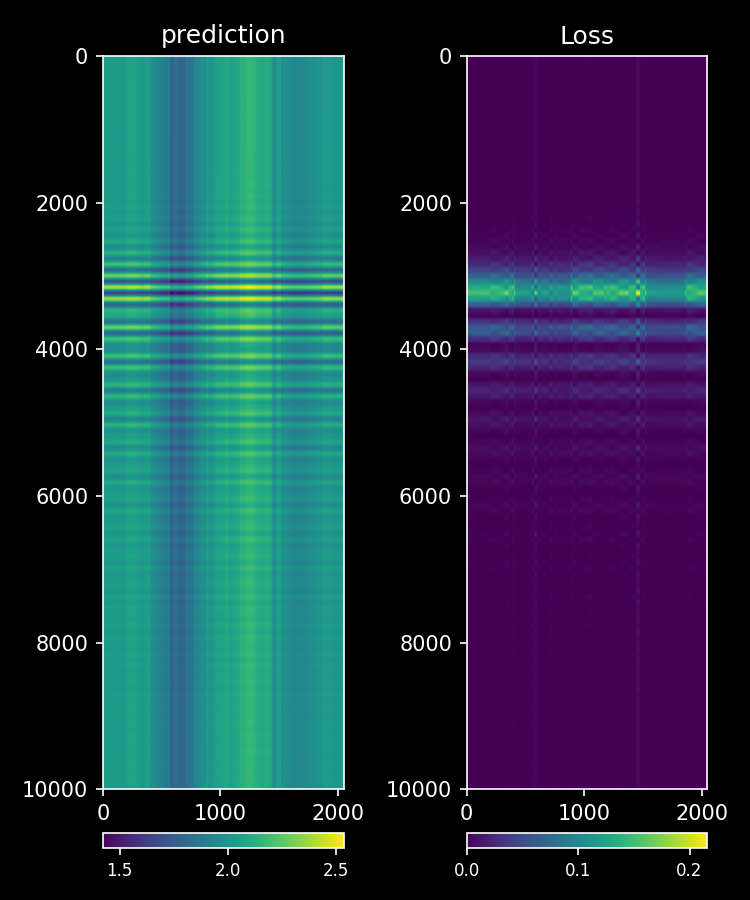

In [50]:
fig, axis = plt.subplots(1, 2, figsize=(5,6), sharex = False, sharey = False, squeeze = False)

def plot(fig, axis, mat, title, cmap = 'viridis'):
    im = axis.imshow(mat, extent = [0,numParticles, iterations, 0], cmap = cmap)
    axis.axis('auto')
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("bottom", size="2%", pad="6%")
    cb1 = fig.colorbar(im, cax=cax1,orientation='horizontal')
    cb1.ax.tick_params(labelsize=8) 
    axis.set_title(title)
    
plot(fig, axis[0,0], torch.vstack(predictions)[-128:,:], title = 'prediction')
plot(fig, axis[0,1], torch.vstack(losses)[-128:,:], title = 'Loss')
    
fig.tight_layout()

In [118]:
from tqdm.notebook import tqdm

In [119]:
pb = tqdm(range(epochs * iterations))
epoch = 0
b, l, w = processDataLoaderIter(pb, iterations, epoch, lr, \
                                dataLoader, dataIter, batchSize, model, optimizer, \
                                particleData, settings, dataSet, \
                                lossFunction, getFeatures, getGroundTruth, None,\
                                train = True, prefix = '', augmentAngle = False, augmentJitter = False, jitterAmount = 0.01)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [113]:
testFile = trainingFiles[2]
testFrame = 0
unrollLength = 32



positions, velocities, areas, dudts, densities, setup = loadFrames(particleData, settings, dataSet, testFile, testFrame + np.arange(unrollLength), device)

i, j, distance, direction = batchedNeighborsearch(positions, setup)
x, u, v, dudt = flatten(positions, velocities, areas, dudts)
x = x[:,None]
distance = distance[:,None]
features = torch.vstack((u, torch.ones_like(v))).mT

In [115]:
predictions = []
with torch.no_grad():
    for i in range(unrollLength):
        predictions.append(modelStep([positions[i]], [velocities[i]], [densities[i]], setup).cpu())
predictions = torch.vstack(predictions)

<IPython.core.display.Javascript object>


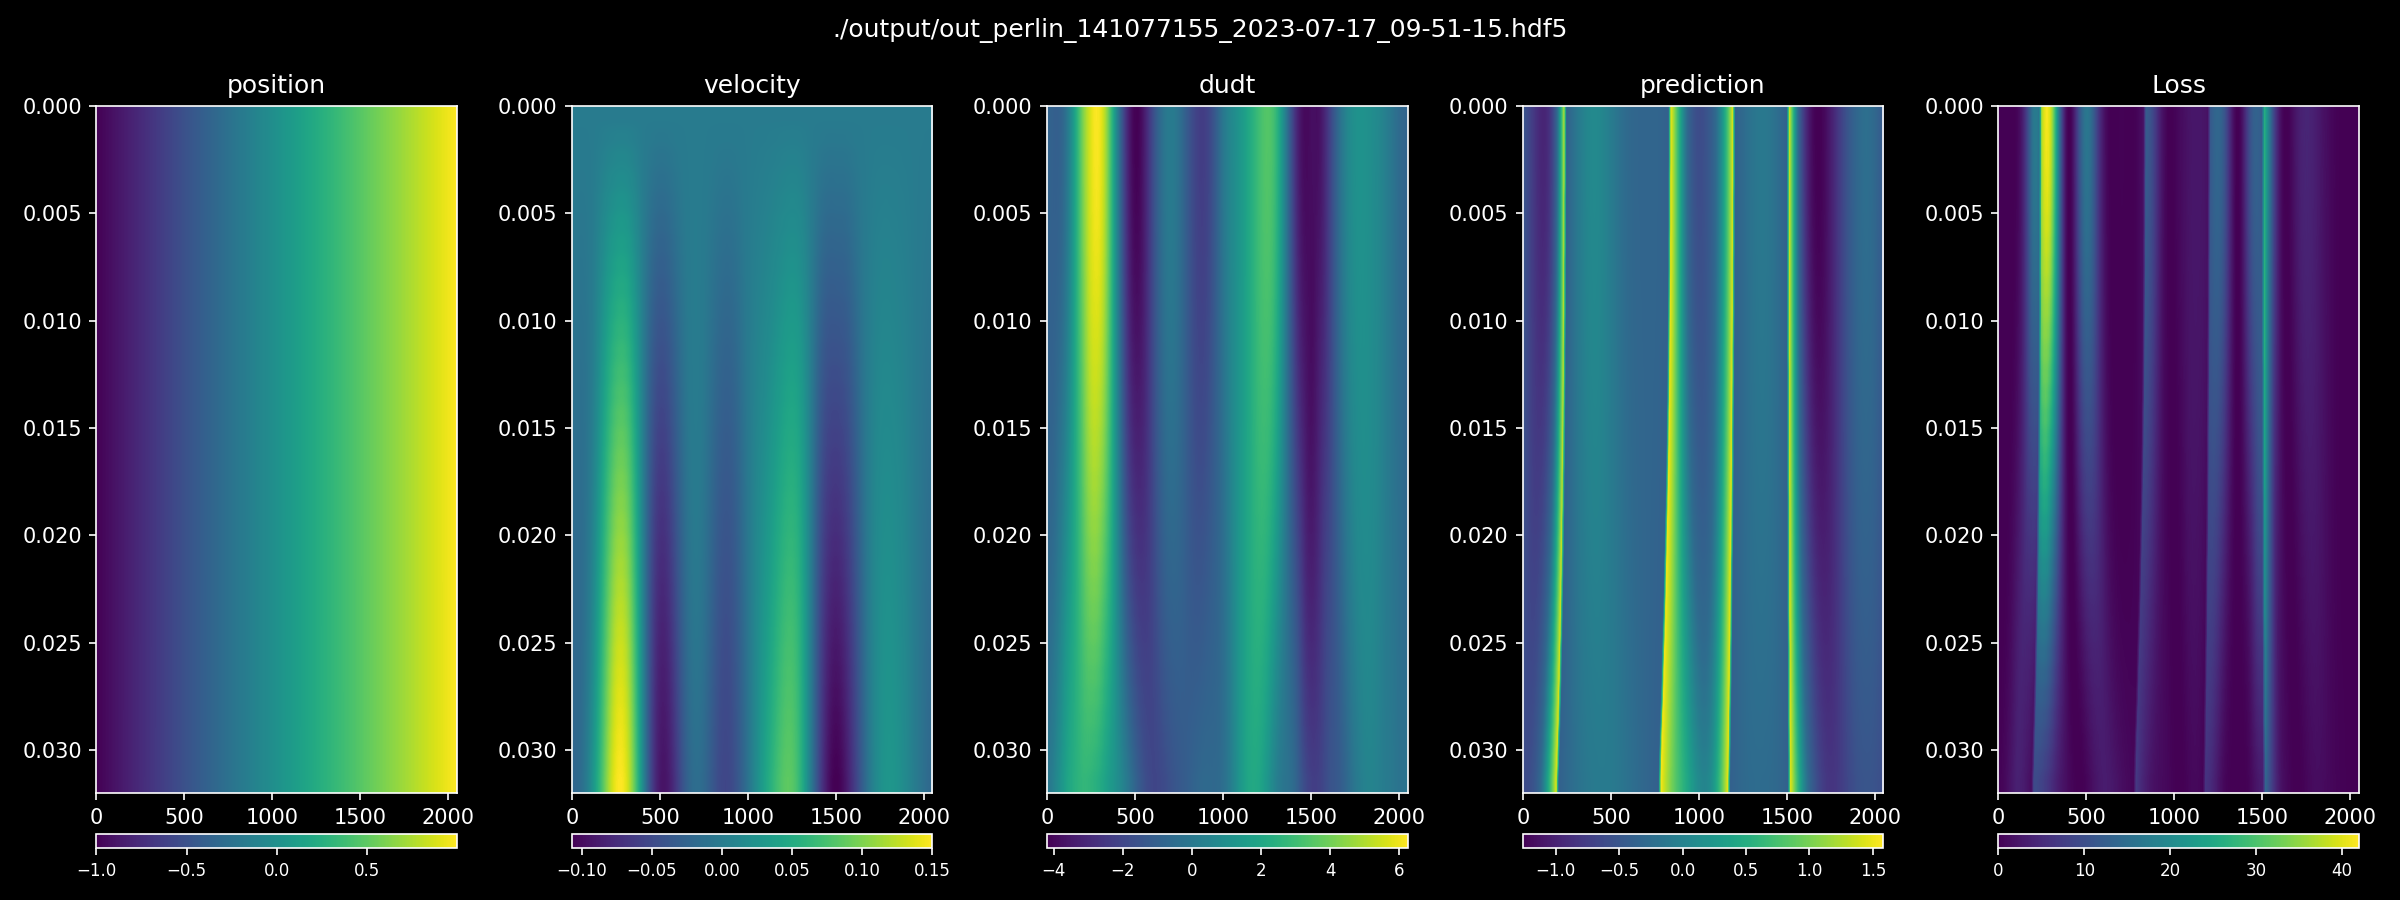

In [116]:

fig, axis = plt.subplots(1, 5, figsize=(16,6), sharex = False, sharey = False, squeeze = False)

def plot(fig, axis, mat, title, cmap = 'viridis'):
    im = axis.imshow(mat, extent = [0,numParticles,dt * (unrollLength + testFrame), testFrame * dt], cmap = cmap)
    axis.axis('auto')
    ax1_divider = make_axes_locatable(axis)
    cax1 = ax1_divider.append_axes("bottom", size="2%", pad="6%")
    cb1 = fig.colorbar(im, cax=cax1,orientation='horizontal')
    cb1.ax.tick_params(labelsize=8) 
    axis.set_title(title)
plot(fig,axis[0,0], x.reshape((unrollLength, numParticles)), 'position')
plot(fig,axis[0,1], u.reshape((unrollLength, numParticles)), 'velocity')
plot(fig,axis[0,2], dudt.reshape((unrollLength, numParticles)) / dt, 'dudt')
plot(fig,axis[0,3], predictions, 'prediction')
plot(fig,axis[0,4], (dudt.reshape((unrollLength, numParticles)) / dt - predictions)**2, 'Loss')
# plot(fig,axis[0,1], fluidDensity, 'density')
# plot(fig,axis[0,2], fluidPressure, 'pressure')
# plot(fig,axis[0,3], fluidVelocities, 'velocity', 'RdBu')
# plot(fig,axis[0,4], dudt, 'dudt', 'RdBu')

fig.suptitle(trainingFiles[0])
fig.tight_layout()

In [51]:

positions, velocities, areas, dudts, setup = loadBatch(particleData, settings, dataSet, bdata, device)

i, j, distance, direction = batchedNeighborsearch(positions, setup)
x, u, v, dudt = flatten(positions, velocities, areas, dudts)
x = x[:,None]
distance = distance[:,None]
features = torch.vstack((u, torch.ones_like(v))).mT

In [52]:
model(features, i, j, distance).reshape(4,2048)

tensor([[-0.0576, -0.0575, -0.0574,  ..., -0.0579, -0.0577, -0.0577],
        [-0.0355, -0.0355, -0.0354,  ..., -0.0357, -0.0357, -0.0356],
        [-0.0245, -0.0244, -0.0242,  ..., -0.0249, -0.0248, -0.0246],
        [-0.0670, -0.0671, -0.0672,  ..., -0.0667, -0.0668, -0.0669]],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)

In [48]:
print(x.shape, x.reshape(4,2048))
print(positions)

torch.Size([8192, 1]) tensor([[-1.0040, -1.0030, -1.0020,  ...,  0.9931,  0.9940,  0.9950],
        [-1.0024, -1.0014, -1.0004,  ...,  0.9945,  0.9955,  0.9966],
        [-0.9568, -0.9558, -0.9547,  ...,  1.0401,  1.0411,  1.0422],
        [-1.0343, -1.0333, -1.0323,  ...,  0.9627,  0.9637,  0.9647]],
       device='cuda:0')
[tensor([-1.0040, -1.0030, -1.0020,  ...,  0.9931,  0.9940,  0.9950],
       device='cuda:0'), tensor([-1.0024, -1.0014, -1.0004,  ...,  0.9945,  0.9955,  0.9966],
       device='cuda:0'), tensor([-0.9568, -0.9558, -0.9547,  ...,  1.0401,  1.0411,  1.0422],
       device='cuda:0'), tensor([-1.0343, -1.0333, -1.0323,  ...,  0.9627,  0.9637,  0.9647],
       device='cuda:0')]
